In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import re
import datetime
import pylab as pl
pl.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sma

In [4]:
def convertDate(d):
    date = datetime.datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p')
    return datetime.date(date.year, date.month, date.day)

In [5]:
crimes = pd.read_csv('Crime_Incident_Reports.csv', converters={'FROMDATE': convertDate})

c:\Users\Jeremy\Anaconda\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [6]:
crimes = crimes.rename(columns = {'FROMDATE': 'Date'})

In [8]:
crimes.columns

Index([u'COMPNOS', u'NatureCode', u'INCIDENT_TYPE_DESCRIPTION',
       u'MAIN_CRIMECODE', u'REPTDISTRICT', u'REPORTINGAREA', u'Date',
       u'WEAPONTYPE', u'Shooting', u'DOMESTIC', u'SHIFT', u'Year', u'Month',
       u'DAY_WEEK', u'UCRPART', u'X', u'Y', u'STREETNAME', u'XSTREETNAME',
       u'Location'],
      dtype='object')

In [7]:
groups = crimes.groupby('Date')

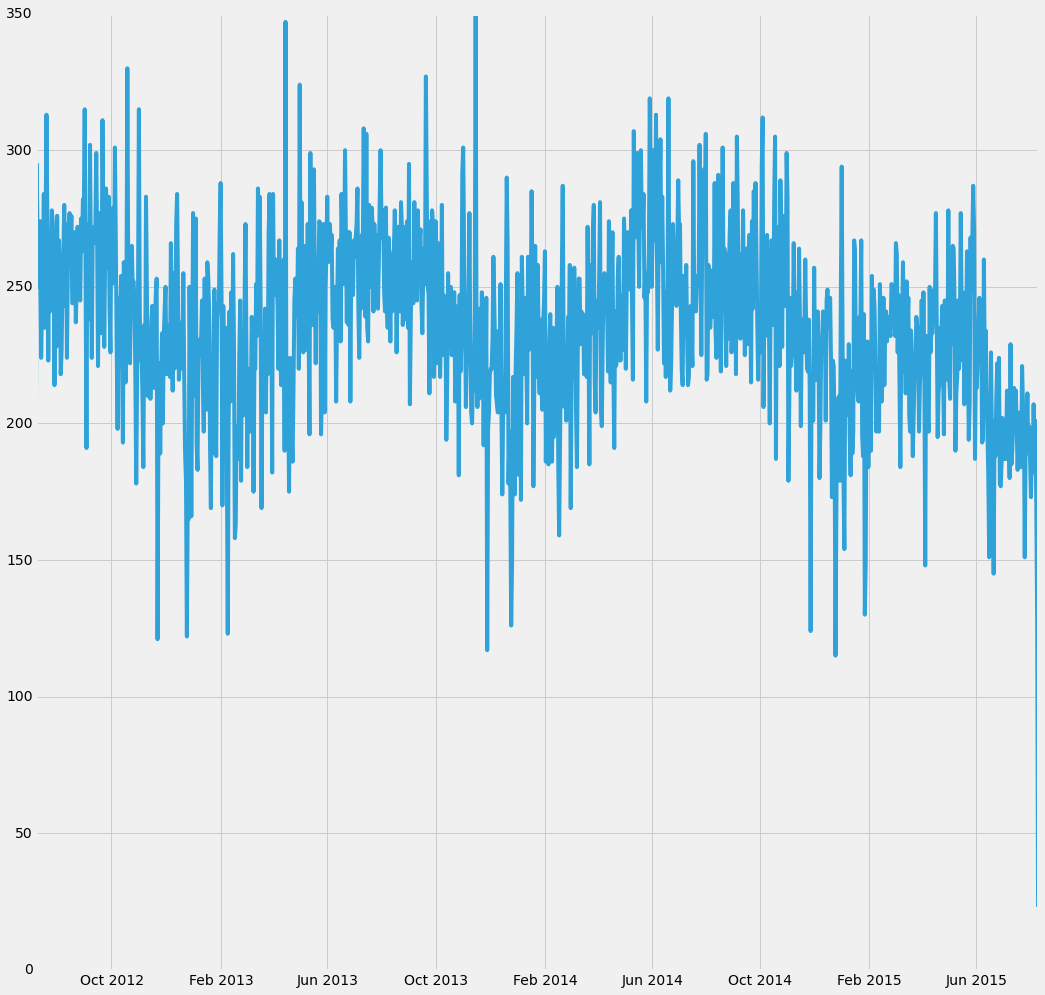

In [11]:
figure, ax = pl.subplots(figsize=(16,16))
ax.plot(crimes['Date'].unique(), groups.count()['NatureCode'])

In [12]:
cycle, trend = sma.tsa.filters.hpfilter(groups.count()['NatureCode'], lamb = 104976000000)

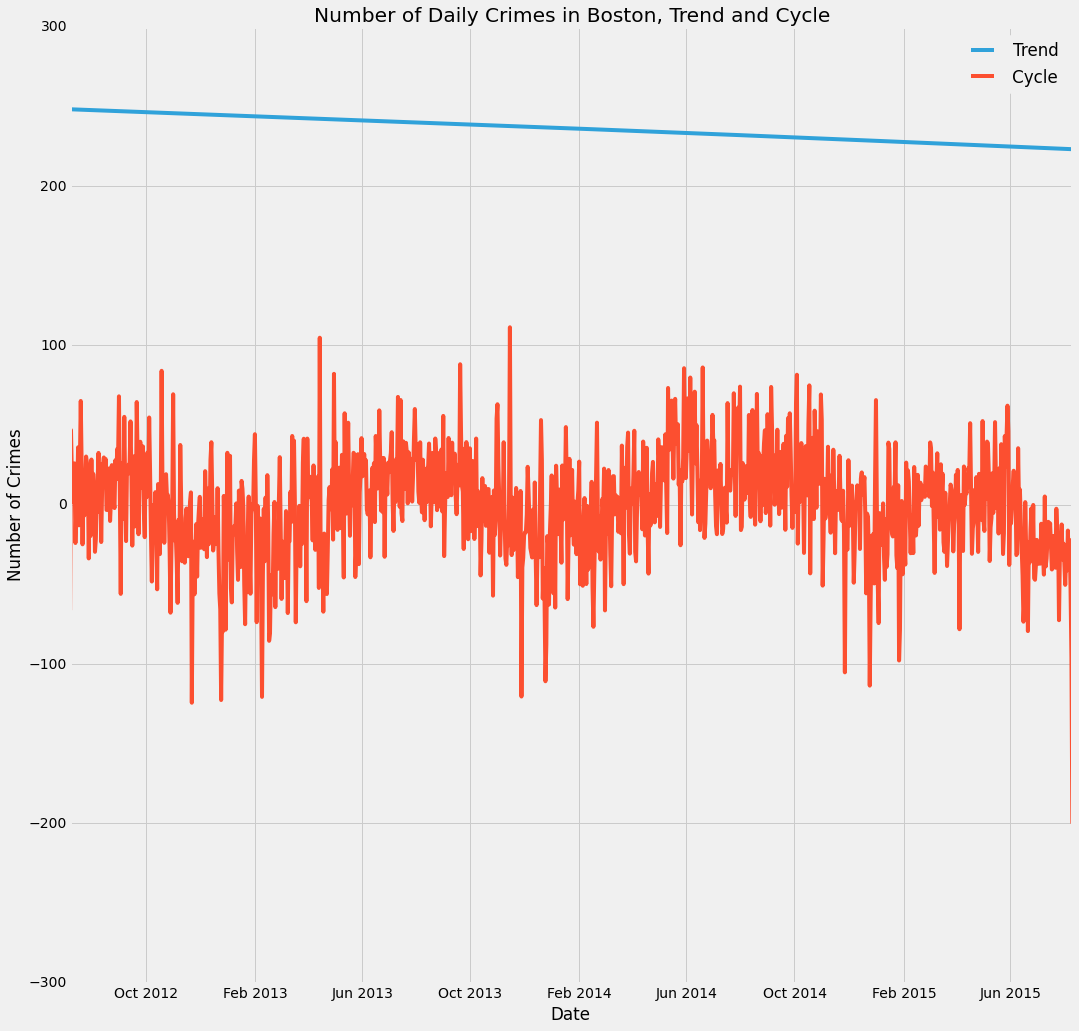

In [14]:
figure, ax = pl.subplots(figsize=(16,16))
trend.plot(label='Trend')
cycle.plot(label='Cycle')
ax.set_title('Number of Daily Crimes in Boston, Trend and Cycle')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Crimes')
ax.legend()

In [15]:
crimes['dow'] = crimes.apply(lambda x: x['Date'].weekday(), axis=1)
crimes['month'] = crimes.apply(lambda x: x['Date'].month, axis=1)

In [16]:
groups = crimes.groupby('Date')

In [17]:
d = {
    'dow': groups.mean()['dow'],
    'month': groups.mean()['month'],
    'count': groups.count()['dow'],
    #'date': complaints['Date'].unique()
}

mod = smf.ols(formula='count ~ C(dow) + C(month)', data = d).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     32.79
Date:                Mon, 09 Nov 2015   Prob (F-statistic):           6.37e-86
Time:                        14:21:10   Log-Likelihood:                -5287.8
No. Observations:                1129   AIC:                         1.061e+04
Df Residuals:                    1111   BIC:                         1.070e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          220.6315      3.361  

In [18]:
def convertStreak(streak):
    # N is post season?
    #if streak == "N":
    #    return float('Nan')
    if not streak:
        return float('Nan')
    sign = -1 if streak[0] == "-" else 1
    return len(streak) * sign

def getDateConverter(year):
    def convertDate(date):
        # Handle duplicate headers
        if date == 'Date':
            return None
        
        # Remove double-header indication (1), (2) and convert to date
        d = datetime.datetime.strptime(re.sub(r'\s\(.*\)', '', date) + ' ' + str(year), '%A %b %d %Y')
        #d.year = year
        return datetime.date(d.year, d.month, d.day)
    
    return convertDate

def convertWL(wl):
    # Covert the W/L column to numeric
    if wl and wl[0] == 'W':
        return 1
    return 0

def readGameLog(csv, convertDate):
    df = pd.read_csv(csv, skip_blank_lines=True, converters={'Streak': convertStreak, 'Date': convertDate, 'W/L': convertWL})
    
    # Remove the headers in the middle of the file and postseason
    df = df.drop(df.index[
        (df.Rk == "Rk") # Drop header rows
    ])
    
    #print [d.days for d in np.diff(df.Date)]
    
    # First game in double headers
    df = df.drop(df.index[(np.append([d.days for d in np.diff(df.Date)], [1]) == 0)])
    
    return df

In [22]:
dfs = []
years = range(2013,2016)
for year in years:
    dfs.append(readGameLog("teams_BOS_%s-schedule-scores_team_schedule.csv" % str(year), getDateConverter(year)))
    
baseball = pd.concat(dfs, ignore_index=True)

In [23]:
#Flag for postseason games
baseball['postseason'] = np.isnan(baseball.Rk.astype('float'))

In [24]:
merged = pd.merge(baseball, crimes, on='Date')

In [25]:
def doStuff(df):
    grouped = df.groupby('Date')
    
    # Get numbers for each day
    streak = []
    counts = []
    dow = []
    post = []
    month = []
    for d in sorted(grouped.groups.keys()):
        mean = grouped.get_group(d).mean()
        streak.append(mean['Streak'])
        dow.append(mean['dow'])
        counts.append(grouped.get_group(d).count()['Date'])
        post.append(mean['postseason'])
        month.append(mean['month'])
        
    # Detrend number of complaints
    cycle, trend = sma.tsa.filters.hpfilter(counts, lamb = 104976000000)
    
    # Plot Complaints vs. Streak
    figure, ax = pl.subplots(figsize=(16,16))
    ax.scatter(streak, cycle)

    mod = smf.ols(formula='c ~ s', data = {'c': cycle, 's': streak}).fit()
    print mod.summary()
    abline_plot(model_results=mod, ax=ax, color='red')
    ax.set_title('Bostom Crimes (Cycle) vs Win Streak (BOS)')
    ax.set_xlabel('Win Streak')
    ax.set_ylabel('Crimes Cycle')
    
    # Run Regression vs. Everything
    mod = smf.ols(formula='c ~ s + C(d) + p + C(m)', data = {'c': cycle, 's': streak, 'd': dow, 'p': post, 'm': month}).fit()
    print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7081
Date:                Mon, 09 Nov 2015   Prob (F-statistic):              0.401
Time:                        14:32:33   Log-Likelihood:                -2104.0
No. Observations:                 445   AIC:                             4212.
Df Residuals:                     443   BIC:                             4220.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0262      1.300     -0.020      0.9

c:\Users\Jeremy\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


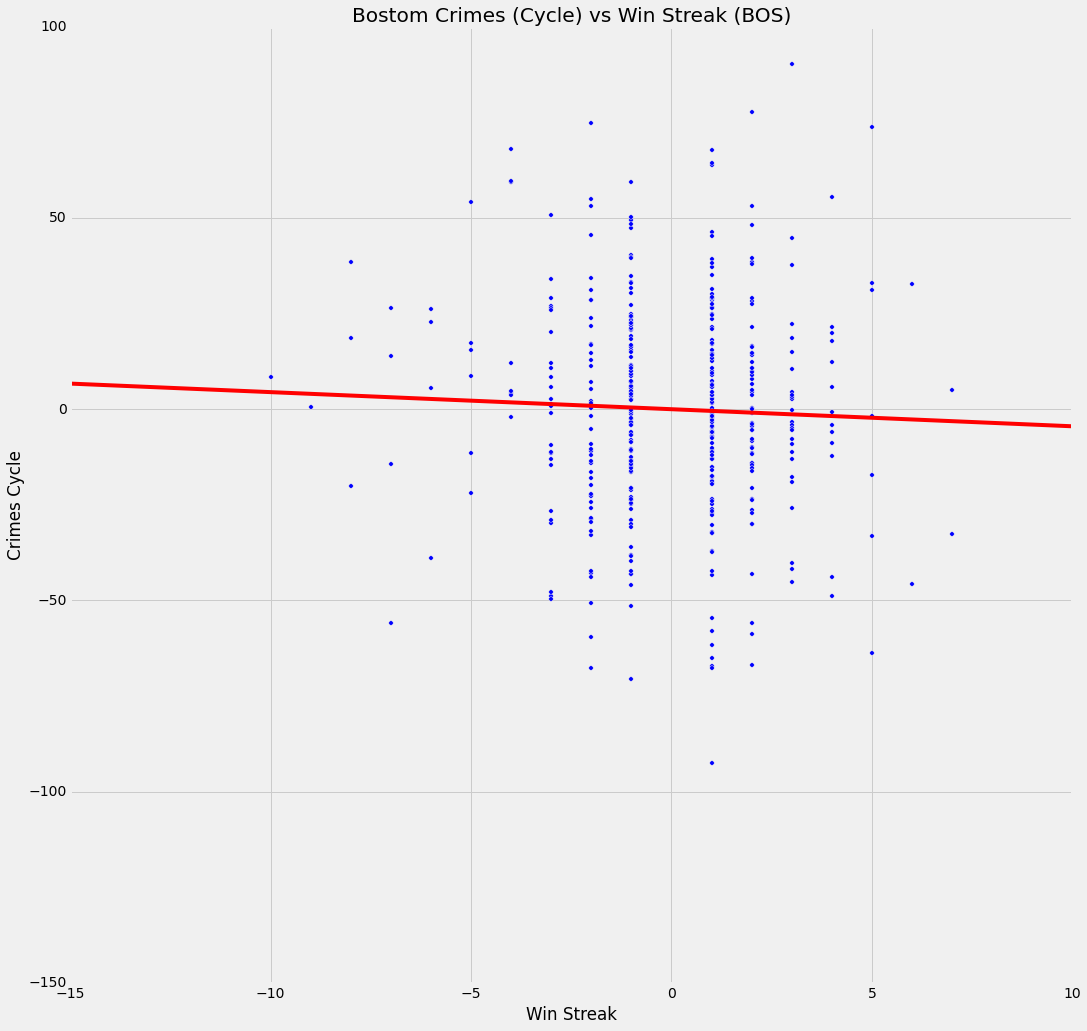

In [26]:
doStuff(merged)